In [8]:
#Imports and Initial Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Load Data
housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.

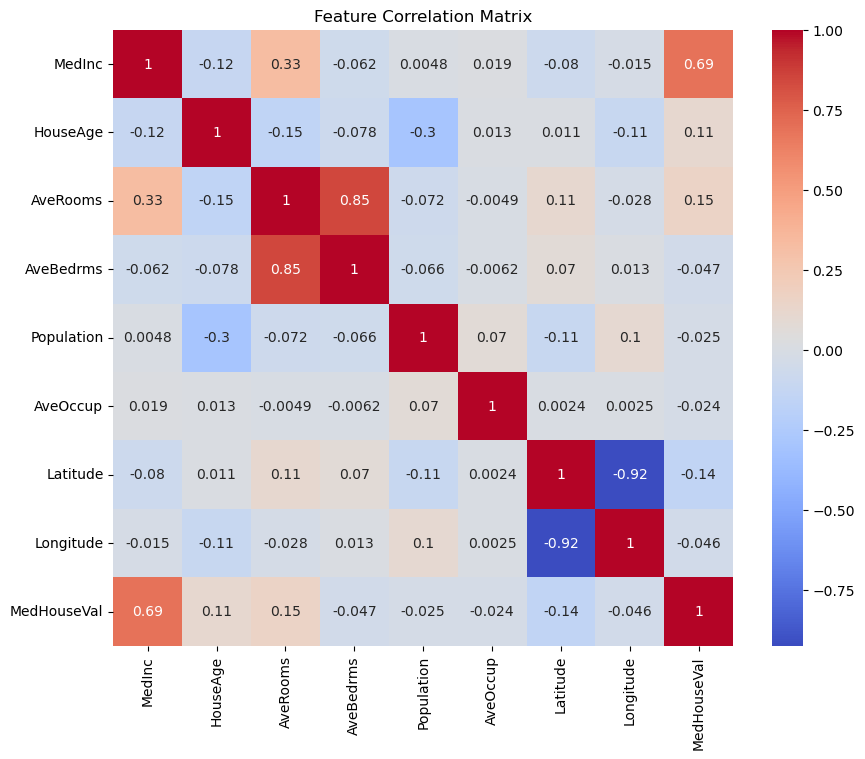

In [10]:
#Data Exploration & Visualization
print(df.info())
print(df.describe())
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show() 

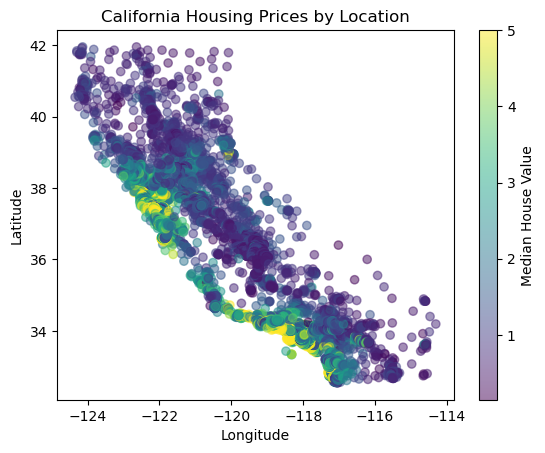

In [11]:
plt.scatter(df['Longitude'], df['Latitude'], c=df['MedHouseVal'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Median House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('California Housing Prices by Location')
plt.show()

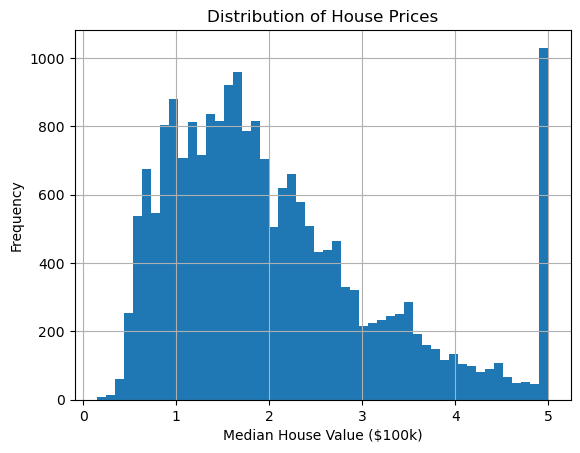

In [12]:
df['MedHouseVal'].hist(bins=50)
plt.xlabel('Median House Value ($100k)')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')
plt.show()

In [13]:
#Feature Engineering
class HousingFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Assumes columns in original order
        rooms_per_household = X[:, 3] / X[:, 6]
        population_per_household = X[:, 4] / X[:, 6]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, 4] / X[:, 3]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
def create_features(df):
    df_new = df.copy()
    df_new['price_per_room'] = df_new['MedHouseVal'] / df_new['AveRooms']
    df_new['age_category'] = pd.cut(df_new['HouseAge'], bins=[0,10,30,50,100], labels=['New','Recent','Mature','Old'])
    df_new['income_category'] = pd.cut(df_new['MedInc'], bins=[0,1.5,3,4.5,6,np.inf], labels=['Very Low','Low','Medium','High','Very High'])
    df_new['coastal_proximity'] = np.sqrt((df_new['Latitude']-34)**2 + (df_new['Longitude']+118)**2)
    return df_new

df = create_features(df)

In [14]:
#Data preprocessing pipeline
X=df.drop('MedHouseVal', axis=1)
y=df['MedHouseVal']
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=['category', 'object']).columns

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('feature_engineering', HousingFeatureEngineer()),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

In [15]:
# 6. Model Selection & Training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Elastic Net': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    results[name] = {
        'mean_rmse': rmse_scores.mean(),
        'std_rmse': rmse_scores.std(),
        'pipeline': pipeline
    }
    print(f"{name}: RMSE = {rmse_scores.mean():.4f} (+/- {rmse_scores.std()*2:.4f})")

Linear Regression: RMSE = 0.3056 (+/- 0.0240)
Ridge Regression: RMSE = 0.3056 (+/- 0.0242)
Lasso Regression: RMSE = 0.3853 (+/- 0.0178)
Elastic Net: RMSE = 0.3703 (+/- 0.0150)
Random Forest: RMSE = 0.0731 (+/- 0.0183)


In [16]:
# 7. Polynomial Regression
poly_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=2, interaction_only=True)),
    ('regressor', Ridge(alpha=1.0))
])
poly_cv_scores = cross_val_score(poly_pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
poly_rmse_scores = np.sqrt(-poly_cv_scores)
print(f"Polynomial Regression: RMSE = {poly_rmse_scores.mean():.4f} (+/- {poly_rmse_scores.std()*2:.4f})")

Polynomial Regression: RMSE = 0.0012 (+/- 0.0024)


In [17]:
# 8. Hyperparameter Tuning
ridge_params = {'regressor__alpha': [0.1,0.5,1.0,2.0,5.0,10.0]}
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])
grid_search = GridSearchCV(ridge_pipeline, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(f"Best Ridge parameters: {grid_search.best_params_}")
print(f"Best Ridge RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

from scipy.stats import randint
rf_params = {
    'regressor__n_estimators': randint(50, 200),
    'regressor__max_depth': randint(3, 20),
    'regressor__min_samples_split': randint(2, 20),
    'regressor__min_samples_leaf': randint(1, 10)
}
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
random_search = RandomizedSearchCV(rf_pipeline, rf_params, n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
print(f"Best Random Forest parameters: {random_search.best_params_}")
print(f"Best Random Forest RMSE: {np.sqrt(-random_search.best_score_):.4f}")

Best Ridge parameters: {'regressor__alpha': 5.0}
Best Ridge RMSE: 0.3057
Best Random Forest parameters: {'regressor__max_depth': 17, 'regressor__min_samples_leaf': 3, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 54}
Best Random Forest RMSE: 0.0765


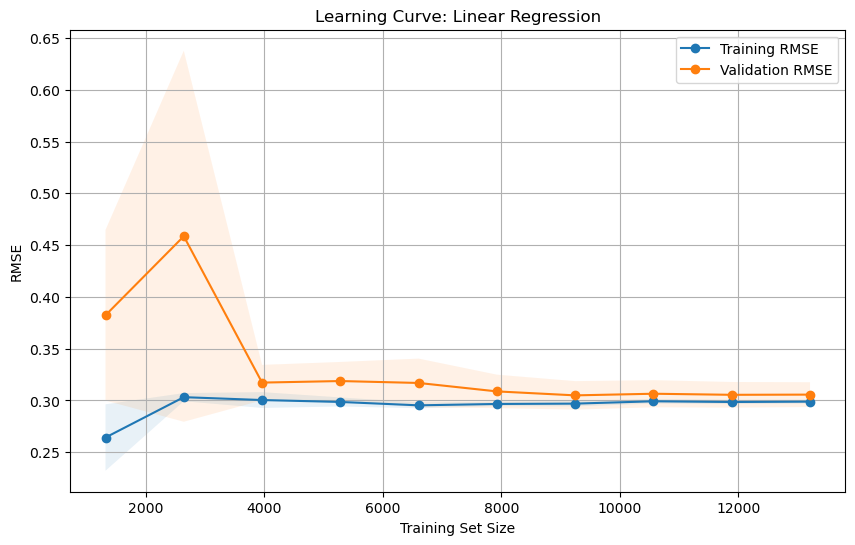

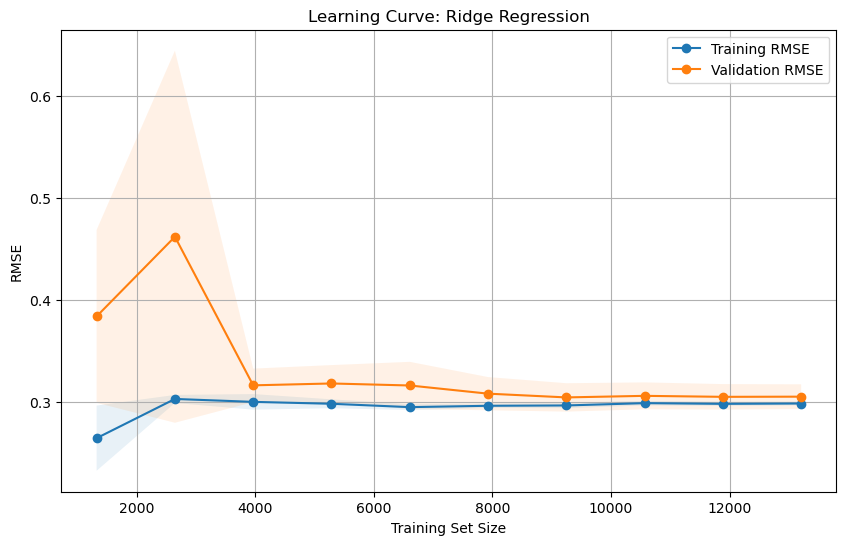

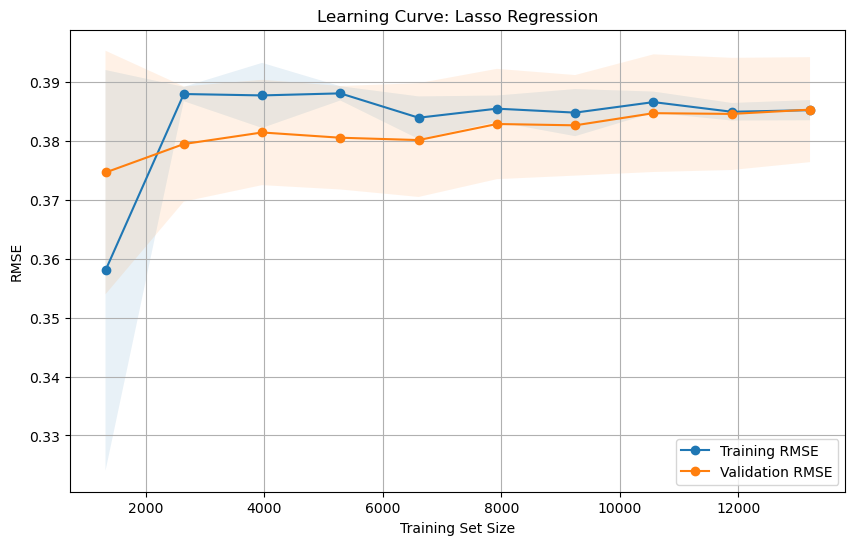

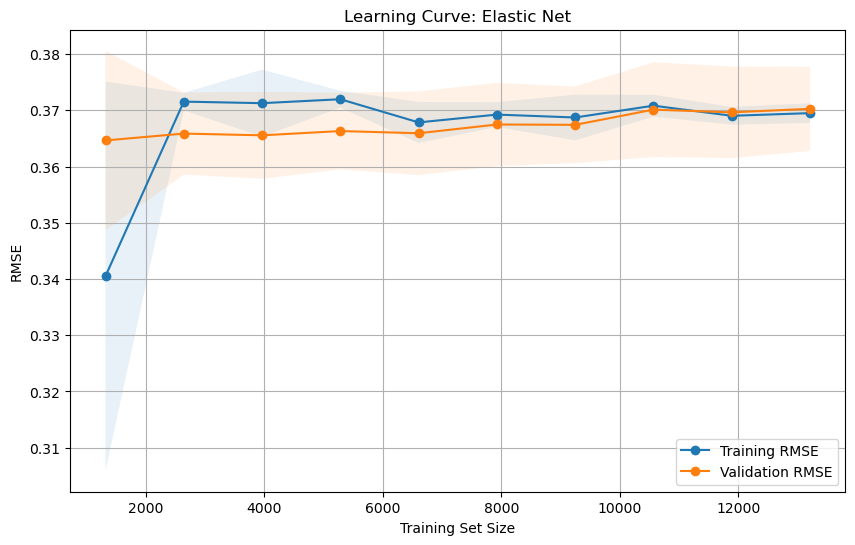

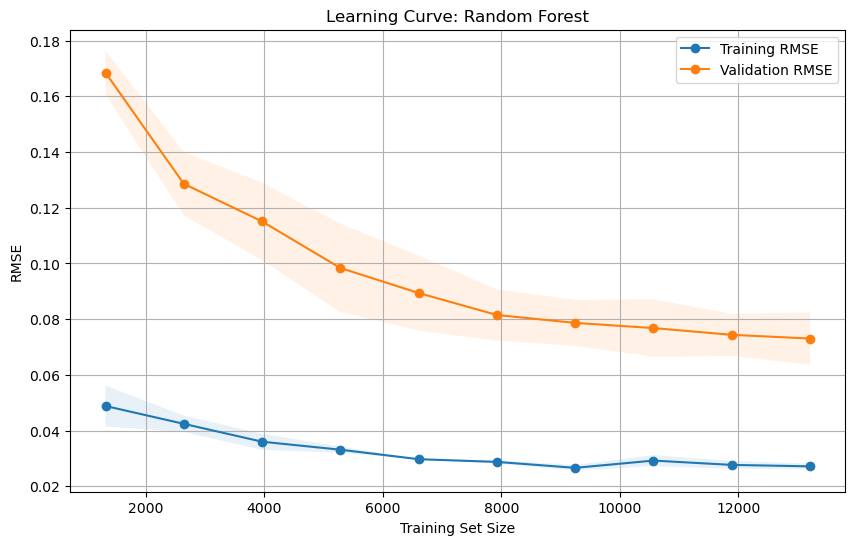

In [18]:
#9. Learning curve function 
def plot_learning_curve(estimator, title, X, y, cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1,1.0,10),
        scoring='neg_mean_squared_error')
    train_rmse = np.sqrt(-train_scores)
    val_rmse = np.sqrt(-val_scores)
    plt.figure(figsize=(10,6))
    plt.plot(train_sizes, train_rmse.mean(axis=1), 'o-', label='Training RMSE')
    plt.plot(train_sizes, val_rmse.mean(axis=1), 'o-', label='Validation RMSE')
    plt.fill_between(train_sizes, train_rmse.mean(axis=1)-train_rmse.std(axis=1), train_rmse.mean(axis=1)+train_rmse.std(axis=1), alpha=0.1)
    plt.fill_between(train_sizes, val_rmse.mean(axis=1)-val_rmse.std(axis=1), val_rmse.mean(axis=1)+val_rmse.std(axis=1), alpha=0.1)
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title(f'Learning Curve: {title}')
    plt.legend()
    plt.grid(True)
    plt.show()
for name, result in results.items():
    plot_learning_curve(result['pipeline'], name, X_train, y_train)



Best Ridge Model Performance:
RMSE: 0.3163
MAE: 0.1860
R²: 0.9237


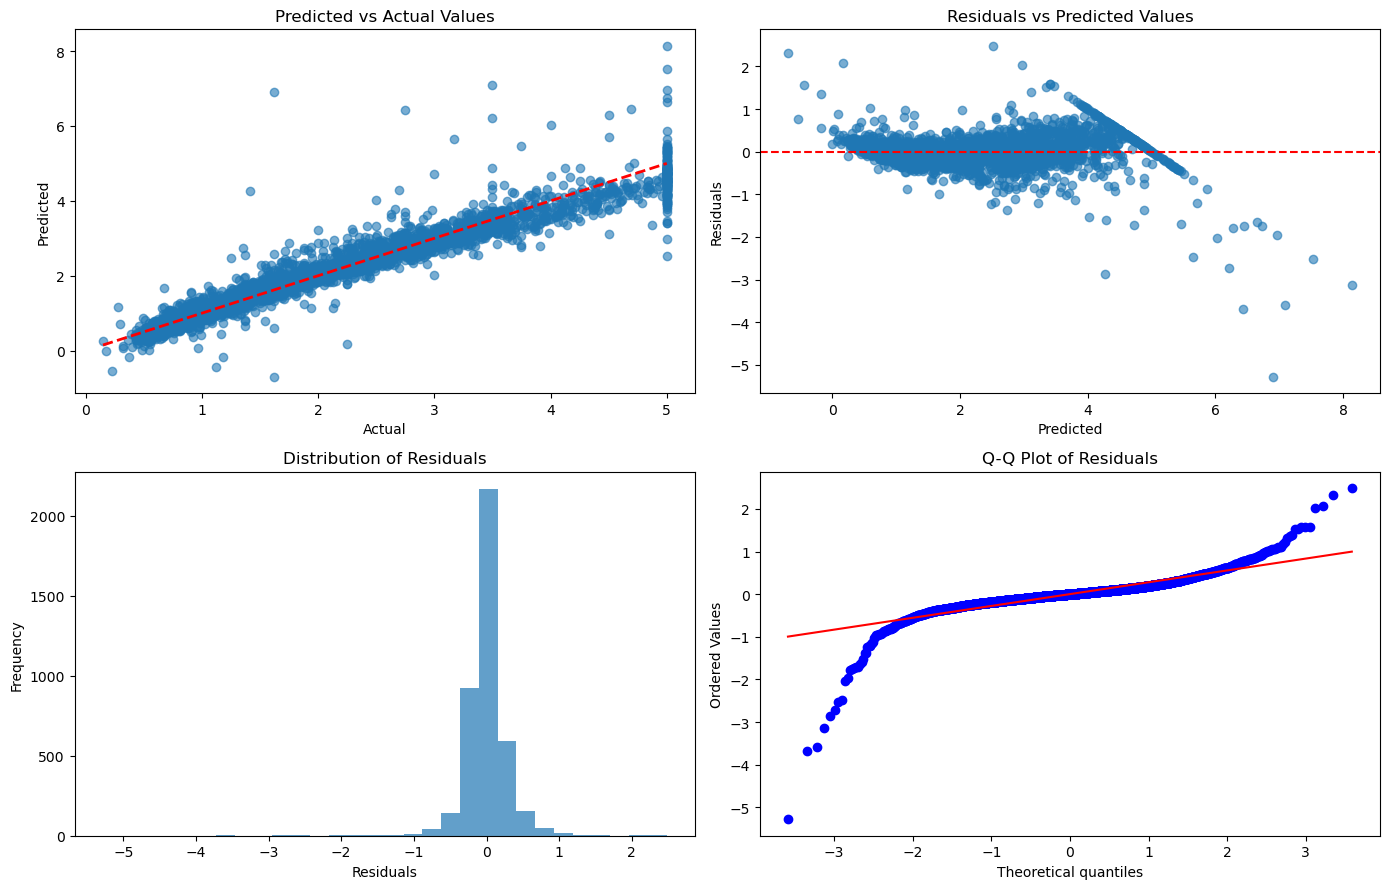

(np.float64(0.31630544606854094), 0.18601188296457766, 0.9236504504517932)

In [19]:
# 10. Model Evaluation and Residual Analysis
def evaluate_model(pipeline, X_test, y_test, model_name):
    y_pred = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\n{model_name} Performance:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    residuals = y_test - y_pred
    fig, axes = plt.subplots(2,2,figsize=(14,9))
    axes[0,0].scatter(y_test, y_pred, alpha=0.6)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual')
    axes[0,0].set_ylabel('Predicted')
    axes[0,0].set_title('Predicted vs Actual Values')
    axes[0,1].scatter(y_pred, residuals, alpha=0.6)
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Predicted')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residuals vs Predicted Values')
    axes[1,0].hist(residuals, bins=30, alpha=0.7)
    axes[1,0].set_xlabel('Residuals')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Distribution of Residuals')
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot of Residuals')
    plt.tight_layout()
    plt.show()
    return rmse, mae, r2

best_model = grid_search.best_estimator_
evaluate_model(best_model, X_test, y_test, "Best Ridge Model")

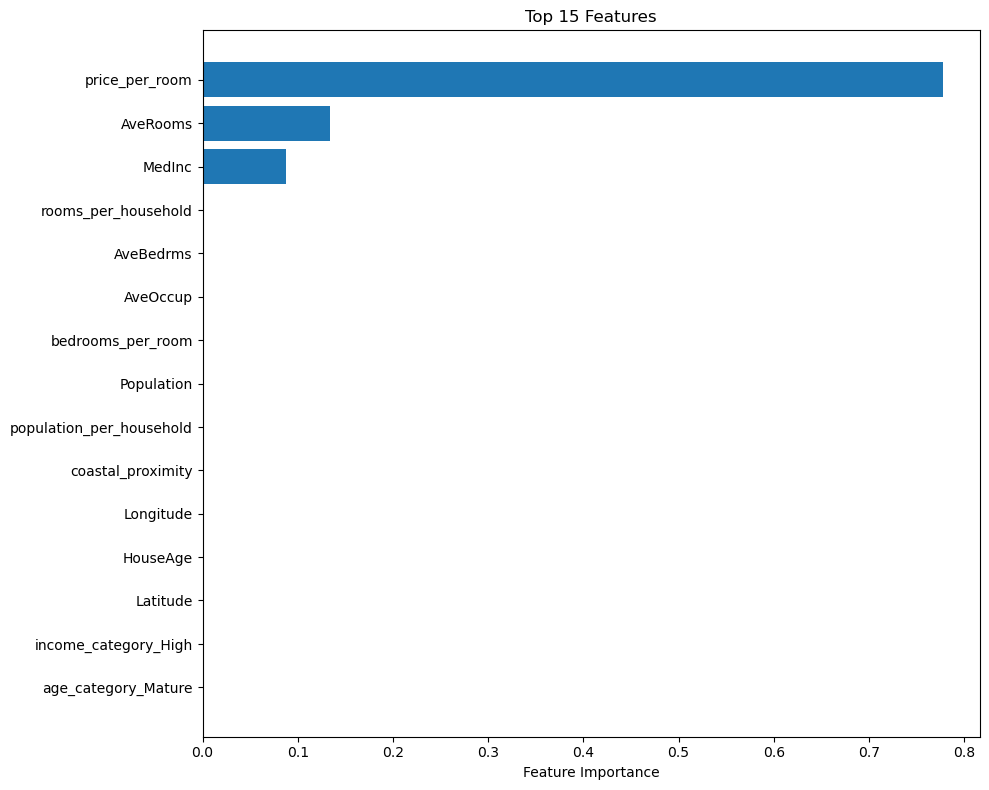

In [ ]:
# 11. Feature Importance for Random Forest
def analyze_feature_importance(pipeline, feature_names):
    reg = pipeline.named_steps['regressor']
    if hasattr(reg, 'feature_importances_'):
        importances = reg.feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_names_out, # type: ignore
            'importance': importances
        }).sort_values('importance', ascending=False)
        plt.figure(figsize=(10,8))
        plt.barh(range(len(importance_df.head(15))), importance_df.head(15)['importance'])
        plt.yticks(range(len(importance_df.head(15))), importance_df.head(15)['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Top 15 Features')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        return importance_df
    else:
        print("Feature importance not available for this model type")
        return None

rf_model = random_search.best_estimator_
importance_df = analyze_feature_importance(rf_model, X.columns)

In [32]:
# 12. Market Insights Generation
def generate_market_insights(df, model_pipeline):
    insights = []
    location_stats = df.groupby(['Latitude','Longitude'])['MedHouseVal'].agg(['mean','std','count'])
    high_value_areas = location_stats[location_stats['mean'] > location_stats['mean'].quantile(0.8)]
    insights.append("High-Value Areas Identified:")
    insights.append(f"Found {len(high_value_areas)} areas with median prices > 80th percentile")
    if importance_df is not None:
        top_3_features = importance_df.head(3)['feature'].tolist()
        insights.append(f"Top 3 price drivers: {', '.join(top_3_features)}")
    scenarios = {
        'Budget': {'MedInc':2.0,'HouseAge':30,'AveRooms':4},
        'Mid-range': {'MedInc':5.0,'HouseAge':15,'AveRooms':6},
        'Luxury': {'MedInc':8.0,'HouseAge':5,'AveRooms':8}
    }
    insights.append("\nPrice Predictions for Segments:")
    for scenario_name, features in scenarios.items():
        sample = X_train.select_dtypes(include=[np.number]).median().to_frame().T
        for col in X_train.select_dtypes(include=['category', 'object']).columns:
            sample[col] = X_train[col].mode()[0]
        for feature, value in features.items():
            if feature in sample.columns:
                sample[feature] = value
        predicted_price = model_pipeline.predict(sample)[0]
        insights.append(f"{scenario_name}: ${predicted_price*100000:.0f}")
    return insights

market_insights = generate_market_insights(df, best_model)
for insight in market_insights:
    print(insight)

High-Value Areas Identified:
Found 2518 areas with median prices > 80th percentile
Top 3 price drivers: price_per_room, AveRooms, MedInc

Price Predictions for Segments:
Budget: $134918
Mid-range: $221019
Luxury: $308636


Model Performance Summary:
                Model     RMSE  RMSE_Std
Polynomial Regression 0.001204  0.001223
        Random Forest 0.073071  0.009170
Random Forest (Tuned) 0.076539  0.000000
     Ridge Regression 0.305570  0.012108
    Linear Regression 0.305649  0.011979
        Ridge (Tuned) 0.305738  0.000000
          Elastic Net 0.370267  0.007487
     Lasso Regression 0.385320  0.008909


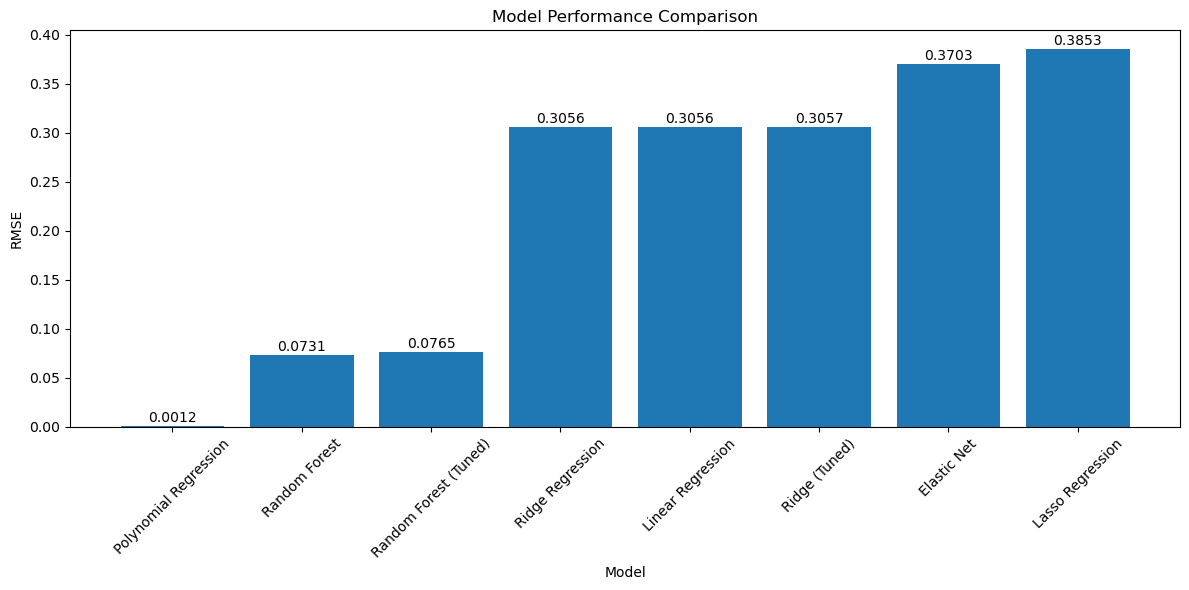

In [ ]:
# 14. Model Performance Summary
def create_performance_summary():
    summary = pd.DataFrame({
        'Model': list(results.keys()),
        'RMSE': [results[model]['mean_rmse'] for model in results.keys()],
        'RMSE_Std': [results[model]['std_rmse'] for model in results.keys()]
    })
    # Add Polynomial Regression
    summary = pd.concat([
        summary,
        pd.DataFrame([{
            'Model': 'Polynomial Regression',
            'RMSE': poly_rmse_scores.mean(),
            'RMSE_Std': poly_rmse_scores.std()
        }])
    ], ignore_index=True)
    # Add tuned models
    summary = pd.concat([
        summary,
        pd.DataFrame([
            {
                'Model': 'Ridge (Tuned)',
                'RMSE': np.sqrt(-grid_search.best_score_),
                'RMSE_Std': 0
            },
            {
                'Model': 'Random Forest (Tuned)',
                'RMSE': np.sqrt(-random_search.best_score_),
                'RMSE_Std': 0
            }
        ])
    ], ignore_index=True)
    summary = summary.sort_values('RMSE')
    print("Model Performance Summary:")
    print("=" * 50)
    print(summary.to_string(index=False))
    plt.figure(figsize=(12,6))
    bars = plt.bar(summary['Model'], summary['RMSE'])
    plt.xlabel('Model')
    plt.ylabel('RMSE')
    plt.title('Model Performance Comparison')
    plt.xticks(rotation=45)
    for bar, rmse in zip(bars, summary['RMSE']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{rmse:.4f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
    return summary

performance_summary = create_performance_summary()